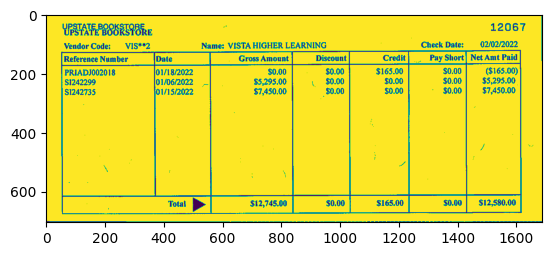

In [1]:
from matplotlib.pyplot import imshow
from lib.relative import path_join
from cv2 import imread, IMREAD_ANYDEPTH, IMREAD_UNCHANGED

test_image = imread(path_join("../", "test_files", "3516793810.tif"), IMREAD_UNCHANGED)
imshow(test_image)


# Step 02: Image Binarization
- To find the threshold and improve text recognition

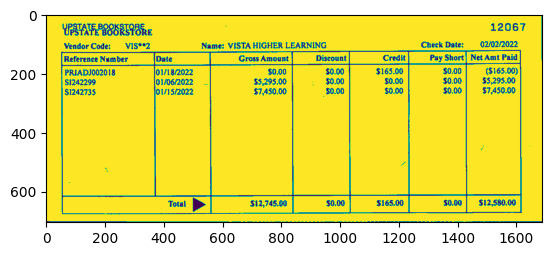

In [2]:
from lib.image.otsu_binarization import otsus_binarization

rt, otsu = otsus_binarization(test_image)
imshow(otsu)

# Step 03: Find Tables in Image
## 1. Image is inverted to emphasize lines.
## 2. Detect Lines using intersection of horizontal and vertical lines.
## 3. Find the contours to be removed.
## 4. Separate `headers`, `body` and `footers`.

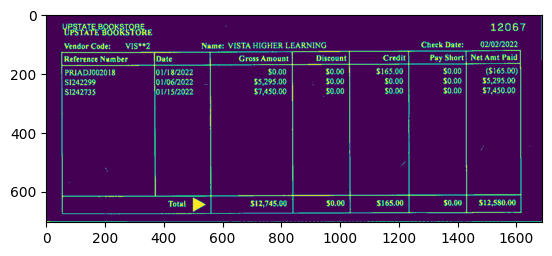

In [3]:
from lib.image.color_space import invert

image_inverted = invert(otsu)
imshow(image_inverted)

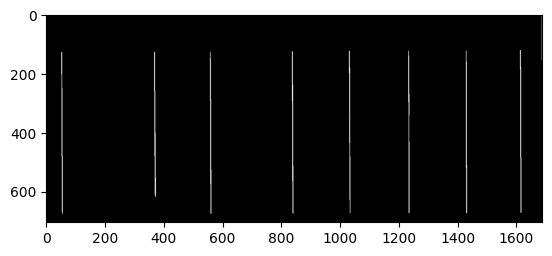

In [4]:
from lib.image.line_detection import detect_lines
from cv2 import getStructuringElement, MORPH_RECT

kernel_length = len(image_inverted) // 40
kernel_vertical = getStructuringElement(MORPH_RECT, (1, kernel_length))

vertical_lines = detect_lines(image_inverted, kernel_vertical)
imshow(vertical_lines, cmap='gray')

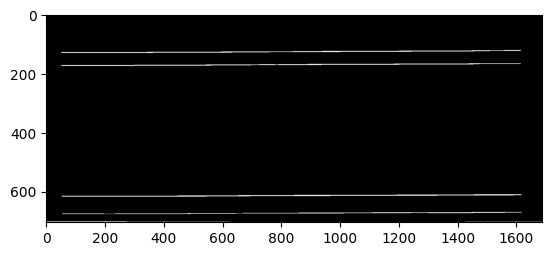

In [5]:
kernel_horizontal = getStructuringElement(MORPH_RECT, (kernel_length, 1))

horizontal_lines = detect_lines(image_inverted, kernel_horizontal)
imshow(horizontal_lines, cmap='gray')

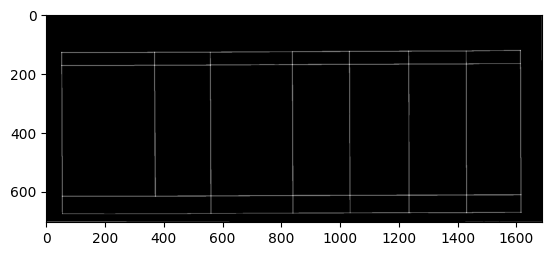

In [6]:
from cv2 import addWeighted

kernel_double_box = getStructuringElement(MORPH_RECT, (2, 2))
both_lines = addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

imshow(both_lines, cmap='gray')

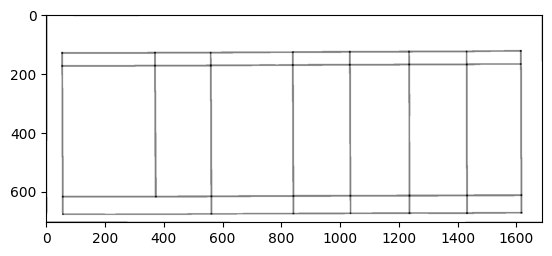

In [7]:
from cv2 import erode

# The points where they intersect are darker.
eroded = erode(~both_lines, kernel_double_box, iterations=3)
imshow(eroded, cmap='gray')

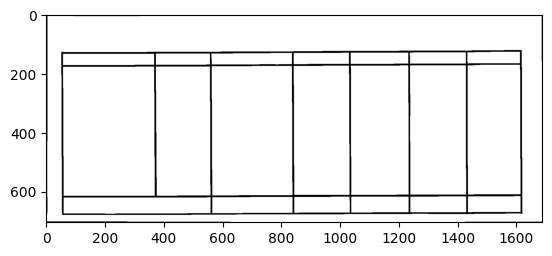

In [8]:
from lib.image.line_detection import detect_boxes

detected_boxes = detect_boxes(image_inverted)
imshow(detected_boxes, cmap='gray')

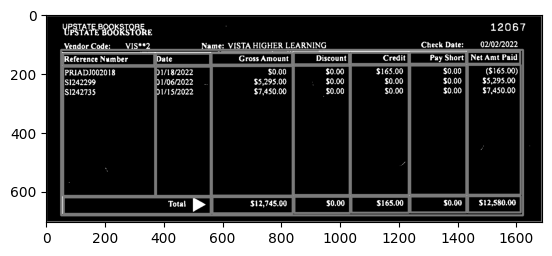

In [9]:
from lib.image.draw import rectangle_points_from_contours
from cv2 import boundingRect, rectangle

from lib.image.line_detection import box_contours

detected_box_contours = box_contours(detected_boxes)

image_contour = image_inverted.copy()

for contour in detected_box_contours:
    rectangle(image_contour, *rectangle_points_from_contours(contour), (123, 0, 0), 5)

imshow(image_contour, cmap='gray')

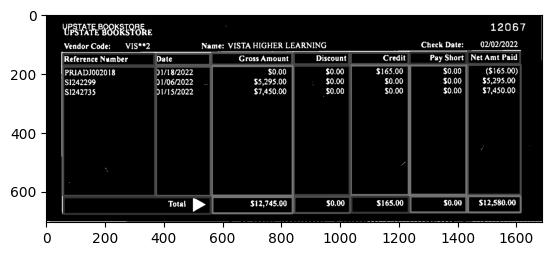

In [10]:
from random import randint
from lib.image.line_detection import filter_contours, sort_contours_vertical

sorted_detected_box_contours = sort_contours_vertical(detected_box_contours)
filtered_detected_boxes = filter_contours(sorted_detected_box_contours)

image_contour_filtered = image_inverted.copy()

for contour in filtered_detected_boxes:
    color = randint(50, 125)
    rectangle(image_contour_filtered, *rectangle_points_from_contours(contour), (color, 0, 125), 5)

imshow(image_contour_filtered, cmap='gray')

In [11]:
from lib.image.line_detection import fragmented_contours_to_rows

headers, body, footer = fragmented_contours_to_rows(filtered_detected_boxes)

> The Above transformations are encapsulated in `get_contours_of_table`.

In [12]:
from lib.image.line_detection import get_contours_of_table

headers, body, footer = get_contours_of_table(test_image)